In [1]:
import numpy as np
import pandas as pd 
from transformers import BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments
from datasets import Dataset
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

/home/minwook0008/bin/anaconda3/envs/MLAp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/minwook0008/bin/anaconda3/envs/MLAp/lib/python3.9/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
# tested in transformers==4.18.0, pytorch==1.7.1 
import torch
import transformers
torch.__version__, transformers.__version__

('2.0.1+cu117', '4.40.0')

In [3]:
device = torch.device("cuda")
device

device(type='cuda')

In [4]:
torch.cuda.is_available()

True

In [4]:
df_train = pd.read_csv('dataset/train_stockemo.csv') 
df_val = pd.read_csv('dataset/val_stockemo.csv')
df_test = pd.read_csv('dataset/test_stockemo.csv')
df_test

,id,date,ticker,emo_label,senti_label,original,processed
0,100067,2020-01-08,AAPL,confusion,bearish,$AAPL with all time highs again the market see...,Apple with all time highs again the market see...
1,100115,2020-01-10,BA,anxiety,bullish,$BA about to explode 🚨\nKeep shorting please,Boeing about to explode [police car light] \n...
2,100175,2020-01-15,SBUX,confusion,bearish,"$SBUX TPO alot of volume at 91.74, thats after...","Starbucks TPO alot of volume at 91.74, thats a..."
3,100234,2020-01-18,TSLA,confusion,bearish,$TSLA down 6$ afterhours right now 🤔,Tesla down 6$ afterhours right now [thinking ...
4,100268,2020-01-22,BA,confusion,bearish,$BA can someone tell me why they haven’t downg...,Boeing can someone tell me why they haven’t do...
...,...,...,...,...,...,...,...
995,109996,2020-12-31,ABNB,optimism,bearish,"$ABNB “sugar daddy puts.” Don’t mind me, I’m j...","Airbnb “sugar daddy puts.” Don’t mind me, I’m ..."
996,109997,2020-12-31,TSLA,disgust,bullish,$TSLA \nGood news... now bears can get help wh...,Tesla \nGood news... now bears can get help wh...
997,109998,2020-12-31,BABA,confusion,bullish,$BABA Who else is glad they sold in 240s yeste...,Alibaba Who else is glad they sold in 240s yes...
998,109999,2020-12-31,CCL,amusement,bullish,$CCL $23 calls for .79 you know what to do 🥳,Carnival $23 calls for .79 you know what to do...


In [5]:
df_cr_test = pd.read_csv('dataset/trans_output.csv')

In [5]:
df_train = df_train.dropna(subset=['senti_label', 'processed'])
df_val = df_val.dropna(subset=['senti_label', 'processed'])
df_test = df_test.dropna(subset=['senti_label', 'processed'])

In [6]:
df_train

,id,date,ticker,emo_label,senti_label,original,processed
0,100001,2020-01-01,AMZN,excitement,bullish,$AMZN Dow futures up by 100 points already 🥳,Amazon Dow futures up by 100 points already [...
1,100002,2020-01-01,TSLA,excitement,bullish,$TSLA Daddy's drinkin' eArly tonight! Here's t...,Tesla Daddy's drinkin' eArly tonight! Here's t...
2,100003,2020-01-01,AAPL,confusion,bullish,$AAPL We’ll been riding since last December fr...,Apple We’ll been riding since last December fr...
3,100004,2020-01-01,TSLA,excitement,bullish,"$TSLA happy new year, 2020, everyone🍷🎉🙏","Tesla happy new year, 2020, everyone [wine gla..."
4,100005,2020-01-01,TSLA,excitement,bullish,"$TSLA haha just a collection of greats...""Mars...","Tesla haha just a collection of greats...""Mars..."
...,...,...,...,...,...,...,...
7995,109536,2020-08-06,AAPL,surprise,bullish,BREAKING NEWS: $AAPL beats Elon Musk and Richa...,BREAKING NEWS: Apple beats Elon Musk and Richa...
7996,109541,2020-08-10,AAPL,belief,bullish,$AAPL why be a 2T giant and not dabble a littl...,Apple why be a 2T giant and not dabble a littl...
7997,109561,2020-08-18,AMZN,ambiguous,bullish,"$AMZN - 3,500 jobs = $3,500 ??? 😁","Amazon - 3,500 jobs = $3,500 ??? [beaming fac..."
7998,109795,2020-10-01,TSLA,surprise,bullish,$TSLA $500c 10/2 at 36k volume 👀👀,Tesla $500c 10/2 at 36k volume [eyes]


In [8]:
df_test

,id,date,ticker,emo_label,senti_label,original,processed
0,100067,2020-01-08,AAPL,confusion,bearish,$AAPL with all time highs again the market see...,Apple with all time highs again the market see...
1,100115,2020-01-10,BA,anxiety,bullish,$BA about to explode 🚨\nKeep shorting please,Boeing about to explode [police car light] \n...
2,100175,2020-01-15,SBUX,confusion,bearish,"$SBUX TPO alot of volume at 91.74, thats after...","Starbucks TPO alot of volume at 91.74, thats a..."
3,100234,2020-01-18,TSLA,confusion,bearish,$TSLA down 6$ afterhours right now 🤔,Tesla down 6$ afterhours right now [thinking ...
4,100268,2020-01-22,BA,confusion,bearish,$BA can someone tell me why they haven’t downg...,Boeing can someone tell me why they haven’t do...
...,...,...,...,...,...,...,...
995,109996,2020-12-31,ABNB,optimism,bearish,"$ABNB “sugar daddy puts.” Don’t mind me, I’m j...","Airbnb “sugar daddy puts.” Don’t mind me, I’m ..."
996,109997,2020-12-31,TSLA,disgust,bullish,$TSLA \nGood news... now bears can get help wh...,Tesla \nGood news... now bears can get help wh...
997,109998,2020-12-31,BABA,confusion,bullish,$BABA Who else is glad they sold in 240s yeste...,Alibaba Who else is glad they sold in 240s yes...
998,109999,2020-12-31,CCL,amusement,bullish,$CCL $23 calls for .79 you know what to do 🥳,Carnival $23 calls for .79 you know what to do...


In [11]:
df_cr_test = df_cr_test.drop(columns=['title'])
df_cr_test

,date,english_title
0,2023-05-07,"SG's plunge takes a breather, but U.S. regiona..."
1,2023-05-07,"The SG crisis is going to calm down, but...Fin..."
2,2023-05-07,[This week's stock market] Differentiation amo...
3,2023-05-07,"[Fundwatch] Le Seraphim, Espa Joule Comeback....."
4,2023-05-07,Stock market beyond U.S. interest rate hike......
...,...,...
1648,2023-01-02,[Market View] The first trading of the new yea...
1649,2023-01-02,[Market Comprehensive] KOSPI fell 0.48% to the...
1650,2023-01-02,"[Closing market] KOSPI, 0.5% for institutional..."
1651,2023-01-02,"Exchange rate on New Year's Day, KRW 1272.6 fo..."


In [12]:
df_cr_test = df_cr_test.rename(columns={'english_title': 'processed'})
df_cr_test

,date,processed
0,2023-05-07,"SG's plunge takes a breather, but U.S. regiona..."
1,2023-05-07,"The SG crisis is going to calm down, but...Fin..."
2,2023-05-07,[This week's stock market] Differentiation amo...
3,2023-05-07,"[Fundwatch] Le Seraphim, Espa Joule Comeback....."
4,2023-05-07,Stock market beyond U.S. interest rate hike......
...,...,...
1648,2023-01-02,[Market View] The first trading of the new yea...
1649,2023-01-02,[Market Comprehensive] KOSPI fell 0.48% to the...
1650,2023-01-02,"[Closing market] KOSPI, 0.5% for institutional..."
1651,2023-01-02,"Exchange rate on New Year's Day, KRW 1272.6 fo..."


In [7]:
selected_columns = ['senti_label', 'processed']
df_train_pre = df_train[selected_columns]
df_val_pre = df_val[selected_columns]
df_test_pre = df_test[selected_columns]
df_test_pre.head()

,senti_label,processed
0,bearish,Apple with all time highs again the market see...
1,bullish,Boeing about to explode [police car light] \n...
2,bearish,"Starbucks TPO alot of volume at 91.74, thats a..."
3,bearish,Tesla down 6$ afterhours right now [thinking ...
4,bearish,Boeing can someone tell me why they haven’t do...


In [6]:
df_cr_test

,press,date,time,title,link,text,cleaned_text,english_title
0,파이낸셜뉴스,2023-05-07,18:29:07,SG發 폭락 한숨 돌렸지만 美 지역은행 '위기설' 변수 [주간 증시 전망],https://finance.naver.com/news/news_read.naver...,NaN,[],"SG's plunge takes a breather, but U.S. regiona..."
1,파이낸셜뉴스,2023-05-07,11:38:03,'SG 사태' 잠잠해지지만...금융 위기 리스크 여전 [주간증시전망],https://finance.naver.com/news/news_read.naver...,NaN,[],"The SG crisis is going to calm down, but...Fin..."
2,아이뉴스24,2023-05-07,10:01:04,[이번주 증시] 실적 시즌 본격화에 종목간 차별화 전망,https://finance.naver.com/news/news_read.naver...,NaN,[],[This week's stock market] Differentiation amo...
3,이데일리,2023-05-07,09:19:01,[펀드와치]르세라핌·에스파 줄컴백…춤추는 K팝 ETF,https://finance.naver.com/news/news_read.naver...,NaN,[],"[Fundwatch] Le Seraphim, Espa Joule Comeback....."
4,이데일리,2023-05-07,09:13:01,美금리인상 넘은 증시…실적발표 속 변동성장세[주간증시전망],https://finance.naver.com/news/news_read.naver...,NaN,[],Stock market beyond U.S. interest rate hike......
...,...,...,...,...,...,...,...,...
1648,조선비즈,2023-01-02,16:31:01,[마켓뷰] 새해 첫 거래 코스피·코스닥 모두 하락…외국인·기관 순매도에 약세 전환,https://finance.naver.com/news/news_read.naver...,NaN,[],[Market View] The first trading of the new yea...
1649,뉴스1,2023-01-02,16:22:33,[시황종합] 코스피 개장일 0.48% 내린 2225선,https://finance.naver.com/news/news_read.naver...,NaN,[],[Market Comprehensive] KOSPI fell 0.48% to the...
1650,뉴시스,2023-01-02,16:07:49,"[마감시황]코스피, 새해 첫날 기관 매물에 0.5%↓",https://finance.naver.com/news/news_read.naver...,NaN,[],"[Closing market] KOSPI, 0.5% for institutional..."
1651,이데일리,2023-01-02,16:06:02,"새해 첫날 환율, 저가 매수에 1272.6원…5거래일 만에 상승[외환마감]",https://finance.naver.com/news/news_read.naver...,NaN,[],"Exchange rate on New Year's Day, KRW 1272.6 fo..."


In [9]:
df_train_pre['senti_label'] = df_train_pre['senti_label'].apply(lambda x: 2 if x == 'bullish' else (1 if x == 'neutral' else 0))
df_val_pre['senti_label'] = df_train_pre['senti_label'].apply(lambda x: 2 if x == 'bullish' else (1 if x == 'neutral' else 0))
df_test_pre['senti_label'] = df_train_pre['senti_label'].apply(lambda x: 2 if x == 'bullish' else (1 if x == 'neutral' else 0))

/tmp/ipykernel_3255237/2219857626.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_pre['senti_label'] = (df_train_pre['senti_label'] == 'bullish').astype(int) * 2
/tmp/ipykernel_3255237/2219857626.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val_pre['senti_label'] = (df_val_pre['senti_label'] == 'bullish').astype(int) * 2
/tmp/ipykernel_3255237/2219857626.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [10]:
df_test_pre.head()

,senti_label,processed
0,0,Apple with all time highs again the market see...
1,2,Boeing about to explode [police car light] \n...
2,0,"Starbucks TPO alot of volume at 91.74, thats a..."
3,0,Tesla down 6$ afterhours right now [thinking ...
4,0,Boeing can someone tell me why they haven’t do...


### load FinBERT pretrained model
The pretrained FinBERT model path on Huggingface is https://huggingface.co/yiyanghkust/finbert-pretrain

In [12]:
model = BertForSequenceClassification.from_pretrained('/home/minwook0008/please/OR2/or2_case_study/finbert_finetuning/temp/checkpoint-1250',num_labels=3).to(device)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')

In [21]:
df_train_pre.rename(columns={'senti_label': 'label'}, inplace=True)
df_val_pre.rename(columns={'senti_label': 'label'}, inplace=True)
df_test_pre.rename(columns={'senti_label': 'label'}, inplace=True)
df_train_pre

/tmp/ipykernel_3255237/139600951.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_pre.rename(columns={'senti_label': 'label'}, inplace=True)
/tmp/ipykernel_3255237/139600951.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val_pre.rename(columns={'senti_label': 'label'}, inplace=True)
/tmp/ipykernel_3255237/139600951.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_pre.rename(columns={'senti_label': 'label'

,label,processed
0,2,Amazon Dow futures up by 100 points already [...
1,2,Tesla Daddy's drinkin' eArly tonight! Here's t...
2,2,Apple We’ll been riding since last December fr...
3,2,"Tesla happy new year, 2020, everyone [wine gla..."
4,2,"Tesla haha just a collection of greats...""Mars..."
...,...,...
7995,2,BREAKING NEWS: Apple beats Elon Musk and Richa...
7996,2,Apple why be a 2T giant and not dabble a littl...
7997,2,"Amazon - 3,500 jobs = $3,500 ??? [beaming fac..."
7998,2,Tesla $500c 10/2 at 36k volume [eyes]


### prepare dataset for fine-tuning

In [22]:
dataset_train = Dataset.from_pandas(df_train_pre)
dataset_val = Dataset.from_pandas(df_val_pre)
dataset_test = Dataset.from_pandas(df_test_pre)

dataset_train = dataset_train.map(lambda e: tokenizer(e['processed'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_val = dataset_val.map(lambda e: tokenizer(e['processed'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_test = dataset_test.map(lambda e: tokenizer(e['processed'], truncation=True, padding='max_length' , max_length=128), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])


Map: 100%|█████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2956.36 examples/s]


In [23]:
dataset_train

Dataset({
    features: ['label', 'processed', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 8000
})

In [24]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy' : accuracy_score(predictions, labels)}

args = TrainingArguments(
        output_dir = 'temp/',
        evaluation_strategy = 'epoch',
        save_strategy = 'epoch',
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=5,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
)

trainer = Trainer(
        model=model,                   
        args=args,                 
        train_dataset=dataset_train,       
        eval_dataset=dataset_val,          
        compute_metrics=compute_metrics
)

trainer.train() 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.533150,0.729000
2,0.520100,0.530443,0.725000
3,0.520100,0.564939,0.757000
4,0.281500,0.666757,0.733000
5,0.281500,0.768391,0.733000


TrainOutput(global_step=1250, training_loss=0.35364760437011716, metrics={'train_runtime': 236.8446, 'train_samples_per_second': 168.887, 'train_steps_per_second': 5.278, 'total_flos': 2631134177280000.0, 'train_loss': 0.35364760437011716, 'epoch': 5.0})

### evaluate on testing set

In [62]:
model.eval()
trainer.predict(dataset_test).metrics

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__. If sentence, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1000
  Batch size = 32


{'test_loss': 0.32989031076431274,
 'test_accuracy': 0.881,
 'test_runtime': 1.4364,
 'test_samples_per_second': 696.197,
 'test_steps_per_second': 5.57}

### save the fine-tuned model

In [63]:
trainer.save_model('finbert-sentiment/')

Saving model checkpoint to finbert-sentiment/
Configuration saved in finbert-sentiment/config.json
Model weights saved in finbert-sentiment/pytorch_model.bin


In [152]:
df = pd.read_csv("/home/minwook0008/please/OR2/or2_case_study/markovChain/S&P 500 2023 Data.csv")

# Categorize states based on the "Change %" column.
def categorize_change(change_percent_str):
    change_percent = float(change_percent_str.replace('%', ''))
    if change_percent > 1:
        return 1  # State 0: Going Up High
    elif 0 <= change_percent <= 1:
        return 2  # State 1: Going Up Low
    elif -1 <= change_percent < 0:
        return 3  # State 2: Going Down Low
    else:
        return 4  # State 3: Going Down High

# Convert "Change %" of each row to state.
df['state'] = df['Change %'].apply(categorize_change)

In [153]:
df

,Date,Price,Open,High,Low,Vol.,Change %,state
0,12/29/2023,"4,769.80","4,782.90","4,788.40","4,752.00",NaN,-0.28%,3
1,12/28/2023,"4,783.40","4,786.40","4,793.30","4,781.00",NaN,0.04%,2
2,12/27/2023,"4,781.60","4,773.40","4,785.40","4,768.90",NaN,0.14%,2
3,12/26/2023,"4,774.80","4,758.90","4,784.70","4,758.40",NaN,0.42%,2
4,12/22/2023,"4,754.60","4,753.90","4,772.90","4,736.80",NaN,0.16%,2
...,...,...,...,...,...,...,...,...
245,01/09/2023,"3,892.10","3,910.80","3,950.60","3,890.40",NaN,-0.08%,3
246,01/06/2023,"3,895.10","3,823.40","3,906.20","3,809.60",NaN,2.28%,1
247,01/05/2023,"3,808.10","3,839.70","3,839.70","3,802.40",NaN,-1.17%,4
248,01/04/2023,"3,853.00","3,840.40","3,873.20","3,815.80",NaN,0.76%,2


In [29]:
list(df_cr_test['processed'])

["SG's plunge takes a breather, but U.S. regional bank's 'crisis theory' variable [Weekly stock market outlook]",
 'The SG crisis is going to calm down, but...Financial Crisis Risks Remain [Weekly Stock Exchange Outlook]',
 "[This week's stock market] Differentiation among stocks is expected due to the full-fledged earnings season",
 '[Fundwatch] Le Seraphim, Espa Joule Comeback...Dancing K-Pop ETF',
 'Stock market beyond U.S. interest rate hike...Volatility in Earnings Announcement [Weekly Stock Exchange Outlook]',
 'Index Dropped By Powell, Apple, JPMorgan Hard Carry [New York Closes]',
 'U.S. local bank stocks collapsed just one day after interest rate hike...a credit crunch dominoes [closes in New York]',
 '[Open in Europe] Down in the beginning of the market...英 0.44%↓',
 '"Expectation of End of U.S. Tightening" - Shanghai\'s first trading session after closing 0.82% ↑ [Asia closes]',
 'KOSPI to close weak "between expectations and concerns" after suspending rate hike [market rall

In [18]:
dataset_cr_test = Dataset.from_pandas(df_cr_test)
dataset_cr_test = dataset_cr_test.map(lambda e: tokenizer(e['processed'], truncation=True, padding='max_length' , max_length=128), batched=True)

Map: 100%|█| 1653/1


In [26]:
dataset_cr_test[]

Dataset({
    features: ['date', 'processed', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1653
})

In [10]:
df_cr_test = df_cr_test.drop(columns=['link'])
df_cr_test

,date,english_title
0,2023-05-07,"SG's plunge takes a breather, but U.S. regiona..."
1,2023-05-07,"The SG crisis is going to calm down, but...Fin..."
2,2023-05-07,[This week's stock market] Differentiation amo...
3,2023-05-07,"[Fundwatch] Le Seraphim, Espa Joule Comeback....."
4,2023-05-07,Stock market beyond U.S. interest rate hike......
...,...,...
1648,2023-01-02,[Market View] The first trading of the new yea...
1649,2023-01-02,[Market Comprehensive] KOSPI fell 0.48% to the...
1650,2023-01-02,"[Closing market] KOSPI, 0.5% for institutional..."
1651,2023-01-02,"Exchange rate on New Year's Day, KRW 1272.6 fo..."


In [25]:
len(df_cr_test)

364

In [26]:
df_cr_test

,date,english_title
0,2023-01-01,[Expect 'January effect' amid recession fears....
1,2023-01-02,[[Market View] The first trading of the new ye...
2,2023-01-03,[[European opening] The early rise in the mark...
3,2023-01-04,[[European Stock Exchange] Eases 獨 Price Conce...
4,2023-01-05,[[European opening] Mixed at the beginning of ...
...,...,...
359,2023-12-27,"[""Taeyoung Construction is just the beginning""..."
360,2023-12-28,[Taeyoung Construction's 'Sungsu-dong Office D...
361,2023-12-29,[Evercore Mark Mahani Presents Expedia As Next...
362,2023-12-30,[I'm scared of eating out...The winner of the ...


In [60]:
result_out = {}
for i in range(len(df_cr_test)):
    date = df_cr_test['date'][i]
    sentences =  df_cr_test['english_title'][i]
    print(sentences)
    inputs = tokenizer(sentences, return_tensors="pt", truncation=True, padding='max_length' , max_length=128).to(device)
    outputs = model(**inputs)[0]
    
    labels = {0:'neutral', 1:'positive',2:'negative'}

    label_output = []
    for idx, sent in enumerate(sentences):
        label_output.append(labels[np.argmax(outputs.detach().cpu().numpy()[idx])])
    print(label_output)
    count = label_output.count('negative')
    total = len(label_output)
    
    percentage = (count / total) * 100
    
    if percentage > 75:
        state = 3
    elif percentage > 50:
        state = 2
    elif percentage > 25:
        state = 1
    else:
        state =  0
    result_out[date] = {'sentences':sentences, 'state': state}

    

["Expect 'January effect' amid recession fears... U.S. Interest Rate Direction Biggest Variables [Weekly Stock Market Outlook]", '[Fundwatch] KOSDAQ Inverse Laughs at Sudden Crash..."Pay attention to the January effect"', '[Weekly Stock Exchange Outlook] Eyes focused on January effects...Stock Market Forecast', "U.S. Stock Exchange Over 'Worst 2022' Could Be Worse In New Year's First Half...[Monthly time]"]
['negative', 'neutral', 'negative', 'neutral']
['[Market View] The first trading of the new year, both KOSPI and KOSDAQ, fell...Weak turn to net selling of foreigners, institutions', '[Market Comprehensive] KOSPI fell 0.48% to the 2225 mark on the opening day of the KOSPI', "[Closing market] KOSPI, 0.5% for institutional sale on New Year's Day↓", "Exchange rate on New Year's Day, KRW 1272.6 for low-priced purchases...a five-day rise [foreign exchange close]", "[Cosdaq closed] It's down 1% in the end...Second-round stocks gain 6%"]
['neutral', 'neutral', 'neutral', 'negative', 'negat

In [61]:
len(result_out)

364

In [62]:
import json
with open('data.json', 'w') as json_file:
    json.dump(result_out, json_file, indent=4)

In [104]:
kappa_list_predict = []
date_list =[]
for i in result_out.keys():
    print(i)
    date = i.replace('-','/')
    date_list.append(date)
    kappa_list_predict.append(result_out[i]['state'])

2023-01-01
2023-01-02
2023-01-03
2023-01-04
2023-01-05
2023-01-06
2023-01-07
2023-01-08
2023-01-09
2023-01-10
2023-01-11
2023-01-12
2023-01-13
2023-01-14
2023-01-15
2023-01-16
2023-01-17
2023-01-18
2023-01-19
2023-01-20
2023-01-21
2023-01-22
2023-01-23
2023-01-24
2023-01-25
2023-01-26
2023-01-27
2023-01-28
2023-01-29
2023-01-30
2023-01-31
2023-02-01
2023-02-02
2023-02-03
2023-02-04
2023-02-05
2023-02-06
2023-02-07
2023-02-08
2023-02-09
2023-02-10
2023-02-11
2023-02-12
2023-02-13
2023-02-14
2023-02-15
2023-02-16
2023-02-17
2023-02-18
2023-02-19
2023-02-20
2023-02-21
2023-02-22
2023-02-23
2023-02-24
2023-02-25
2023-02-26
2023-02-27
2023-02-28
2023-03-01
2023-03-02
2023-03-03
2023-03-04
2023-03-05
2023-03-06
2023-03-07
2023-03-08
2023-03-09
2023-03-10
2023-03-11
2023-03-12
2023-03-13
2023-03-14
2023-03-15
2023-03-16
2023-03-17
2023-03-18
2023-03-19
2023-03-20
2023-03-21
2023-03-22
2023-03-23
2023-03-24
2023-03-25
2023-03-26
2023-03-27
2023-03-28
2023-03-29
2023-03-30
2023-03-31
2023-04-01

In [109]:
len(kappa_list_raw)

250

In [108]:
kappa_list_raw = []
for i in range(len(df)):
    if df['Date'][i] in date_list:
        kappa_list_raw.append(df['state'][i])

In [96]:
len(kappa_list_predict)

364

In [84]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y').dt.strftime('%Y/%m/%d')

In [103]:
len(kappa_list_raw)

250

[3,
 2,
 2,
 2,
 2,
 1,
 4,
 2,
 2,
 3,
 2,
 1,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 2,
 2,
 3,
 2,
 3,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 1,
 3,
 1,
 3,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 3,
 4,
 4,
 2,
 3,
 4,
 3,
 4,
 3,
 1,
 3,
 3,
 2,
 2,
 2,
 1,
 3,
 2,
 4,
 2,
 3,
 2,
 2,
 4,
 2,
 3,
 4,
 3,
 3,
 2,
 4,
 2,
 2,
 3,
 2,
 2,
 3,
 3,
 3,
 2,
 3,
 2,
 1,
 2,
 2,
 4,
 1,
 3,
 2,
 3,
 3,
 3,
 4,
 2,
 3,
 2,
 3,
 3,
 2,
 3,
 3,
 4,
 3,
 2,
 2,
 3,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 2,
 1,
 2,
 3,
 1,
 3,
 3,
 2,
 3,
 3,
 3,
 1,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 3,
 1,
 2,
 3,
 2,
 1,
 2,
 3,
 4,
 2,
 3,
 2,
 1,
 3,
 2,
 3,
 3,
 2,
 3,
 2,
 1,
 3,
 3,
 4,
 3,
 2,
 1,
 3,
 4,
 2,
 2,
 3,
 3,
 2,
 2,
 3,
 1,
 3,
 2,
 2,
 2,
 3,
 3,
 2,
 1,
 2,
 1,
 3,
 2,
 2,
 2,
 4,
 1,
 2,
 4,
 1,
 3,
 1,
 3,
 4,
 4,
 2,
 4,
 2,
 1,
 2,
 3,
 3,
 2,
 4,
 2,
 3,
 4,
 3,
 4,
 2,
 3,
 1,
 2,
 3,
 4,
 1,
 3,
 4,
 1,
 1,
 1,
 4,
 2,
 1,
 3,
 3,
 1,
 1,
 3,
 4,
 3,
 2,
 2,
 1,
 2,
 3,
 1,
 4,
 2,
 3]

In [134]:
from sklearn.metrics import cohen_kappa_score

kappa_score = cohen_kappa_score(kappa_list_raw, kappa_list_predict)

In [135]:
kappa_list_raw

0.8398902104300091

/home/minwook0008/bin/anaconda3/envs/MLAp/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/minwook0008/bin/anaconda3/envs/MLAp/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


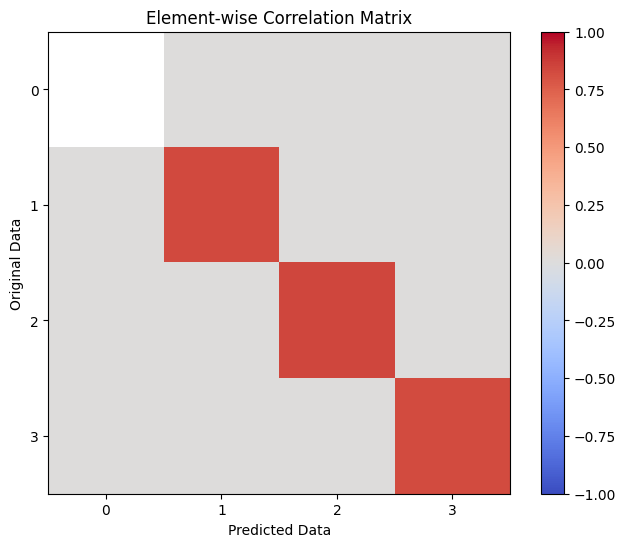

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_element_wise_matches(list1, list2):
    elements = [0, 1, 2, 3]
    matches = {element: [] for element in elements}
    
    for element in elements:
        binary_list1 = [1 if x == element else 0 for x in list1]
        binary_list2 = [1 if x == element else 0 for x in list2]
        
        correlation = np.corrcoef(binary_list1, binary_list2)[0, 1]
        matches[element] = correlation
    
    return matches

# 상관관계 매트릭스 계산
matches = calculate_element_wise_matches(kappa_list_raw, kappa_list_predict)

# 상관관계 매트릭스를 데이터프레임으로 변환
elements = [0, 1, 2, 3]
correlation_matrix = np.zeros((4, 4))
for element in elements:
    correlation_matrix[element, element] = matches[element]

df = pd.DataFrame(correlation_matrix, index=elements, columns=elements)

# 상관관계 매트릭스 시각화
plt.figure(figsize=(8, 6))
plt.title('Element-wise Correlation Matrix')
heatmap = plt.imshow(df, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(heatmap)
plt.xticks(range(len(df.columns)), df.columns)
plt.yticks(range(len(df.index)), df.index)
plt.xlabel('Predicted Data')
plt.ylabel('Original Data')
plt.show()


In [131]:
pip install matplotlib

  Using cached contourpy-1.2.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 kB 759.7 kB/s eta 0:00:00 kB/s eta 0:00:01:01
  Using cached kiwisolver-1.4.5-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 334.0 kB/s eta 0:00:00m eta 0:00:010:00:01
Using cached contourpy-1.2.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (304 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 12.5 MB/s eta 0:00:00m eta 0:00:010:01
Using cached kiwisolver-1.4.5-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
Using cached pyparsing-3.1.2-py3-none-any.whl (103 kB)
Note: you may need to restart the kernel to use updated packages.

In [143]:
kappa_list_predict
date_list

['2023/01/01',
 '2023/01/02',
 '2023/01/03',
 '2023/01/04',
 '2023/01/05',
 '2023/01/06',
 '2023/01/07',
 '2023/01/08',
 '2023/01/09',
 '2023/01/10',
 '2023/01/11',
 '2023/01/12',
 '2023/01/13',
 '2023/01/14',
 '2023/01/15',
 '2023/01/16',
 '2023/01/17',
 '2023/01/18',
 '2023/01/19',
 '2023/01/20',
 '2023/01/21',
 '2023/01/22',
 '2023/01/23',
 '2023/01/24',
 '2023/01/25',
 '2023/01/26',
 '2023/01/27',
 '2023/01/28',
 '2023/01/29',
 '2023/01/30',
 '2023/01/31',
 '2023/02/01',
 '2023/02/02',
 '2023/02/03',
 '2023/02/04',
 '2023/02/05',
 '2023/02/06',
 '2023/02/07',
 '2023/02/08',
 '2023/02/09',
 '2023/02/10',
 '2023/02/11',
 '2023/02/12',
 '2023/02/13',
 '2023/02/14',
 '2023/02/15',
 '2023/02/16',
 '2023/02/17',
 '2023/02/18',
 '2023/02/19',
 '2023/02/20',
 '2023/02/21',
 '2023/02/22',
 '2023/02/23',
 '2023/02/24',
 '2023/02/25',
 '2023/02/26',
 '2023/02/27',
 '2023/02/28',
 '2023/03/01',
 '2023/03/02',
 '2023/03/03',
 '2023/03/04',
 '2023/03/05',
 '2023/03/06',
 '2023/03/07',
 '2023/03/

In [149]:
data ={'date':list(df['Date']), 'state':kappa_list_predict}

In [151]:
last_df = pd.DataFrame(data)
last_df

,date,state
0,12/29/2023,1
1,12/28/2023,3
2,12/27/2023,3
3,12/26/2023,2
4,12/22/2023,1
...,...,...
245,01/09/2023,3
246,01/06/2023,1
247,01/05/2023,4
248,01/04/2023,2


In [155]:
last_df.to_csv('final_predict.csv',index=False)